In [3]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate

In [4]:
### TO DO
### 1 Can look at bounds research and how they effect optimising parameters
### 2 Look at could be interpolation techniques. Whether to use griddata or rbfinterpolator. Bit of research could be conducted here
### 3 Check L2 norm
### 4 check 1d

In [5]:
### Questions / FIXME
### How do I encorporate error bars / noise appropriately
### How do I plot relevant error bars in higher dimension
### Interpolation is inside known points by defn. How do I know what points are known when getting a cross-section

In [6]:
### Good Things
### Function to plot contour plot that interpolates for you. tricontourf
### in GPR argument normalize gets y to be centred on 0.... handier

## Bringing in the data and plotting

In [8]:
columns = ["x","y","z","error"]
data = pd.read_table("Downsampled_SEOB_M75_Q2_2Ddata.txt",names = columns)


x = data['x'].values
y = data['y'].values
z = data['z'].values
print(y.shape)
print(x.shape)
print(z.shape)

## FIXME  need to mean revert y !!!

(49,)
(49,)
(49,)


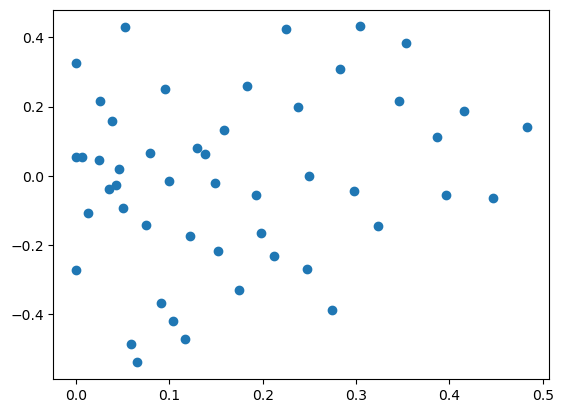

In [53]:
plt.scatter(x,y)

### Using tricontourf

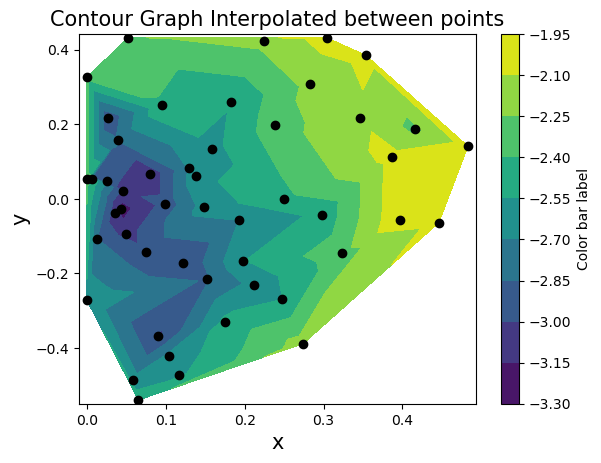

In [56]:
f, ax = plt.subplots()
contour = ax.tricontourf(x, y, z, levels=10, cmap="viridis")  
## FIXME research tricontourf and how it interpolates between points
ax.plot(x, y, 'ko')  

ax.set_xlim([x.min() - 0.01, x.max() + 0.01])
ax.set_ylim([y.min() - 0.01, y.max() + 0.01])

cbar = plt.colorbar(contour, ax=ax, extend='both')  
cbar.set_label("Color bar label")  
plt.xlabel('x', size = 15)
plt.ylabel('y', size = 15)
plt.title('Contour Graph Interpolated between points', size = 15)
plt.show()

### Using tripcolor 

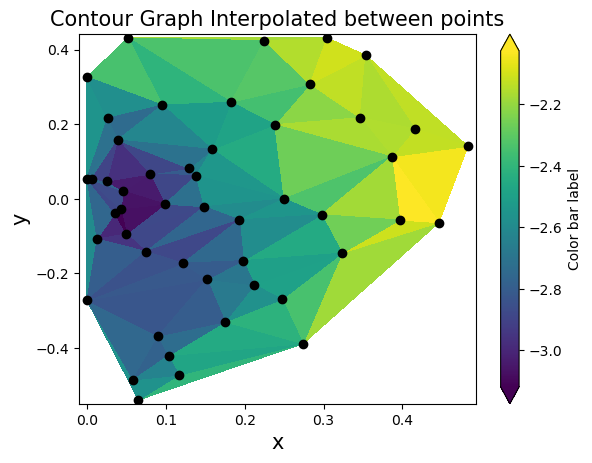

In [59]:
f, ax = plt.subplots()
contour = ax.tripcolor(x, y, z, alpha = 1 )  
## FIXME research tricontourf and how it interpolates between points
ax.plot(x, y, 'ko')  

ax.set_xlim([x.min() - 0.01, x.max() + 0.01])
ax.set_ylim([y.min() - 0.01, y.max() + 0.01])


cbar = plt.colorbar(contour, ax=ax, extend='both')  
cbar.set_label("Color bar label")  
plt.xlabel('x', size = 15)
plt.ylabel('y', size = 15)
plt.title('Contour Graph Interpolated between points', size = 15)
plt.show()

## GPR on this 2d data

In [62]:
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = (z).reshape(-1,1)

In [64]:
guess_l = (1., 1.)  
bounds_l = ((1e-20,1.),) * 2  
guess_n = 1.  
bounds_n = (1e-20, 1.) 
kernel = (RBF(length_scale=guess_l, length_scale_bounds=bounds_l)+ WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n))

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, train_size = 0.9, random_state = 1)

In [68]:
## Parameter called normalize_y which takes mean away when when conduction GPR then when predicting adds the mean back

### FIXME test normalize
gpr = GaussianProcessRegressor(kernel,normalize_y=True ,n_restarts_optimizer=10)
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10, normalize_y=True)

In [70]:
print(gpr.kernel_)

RBF(length_scale=[0.0816, 0.373]) + WhiteKernel(noise_level=0.16)


In [72]:
Zfit, Zstd = gpr.predict(X, return_std=True)
zstd = Zstd.reshape(x.shape)
zfit = Zfit.reshape(x.shape)

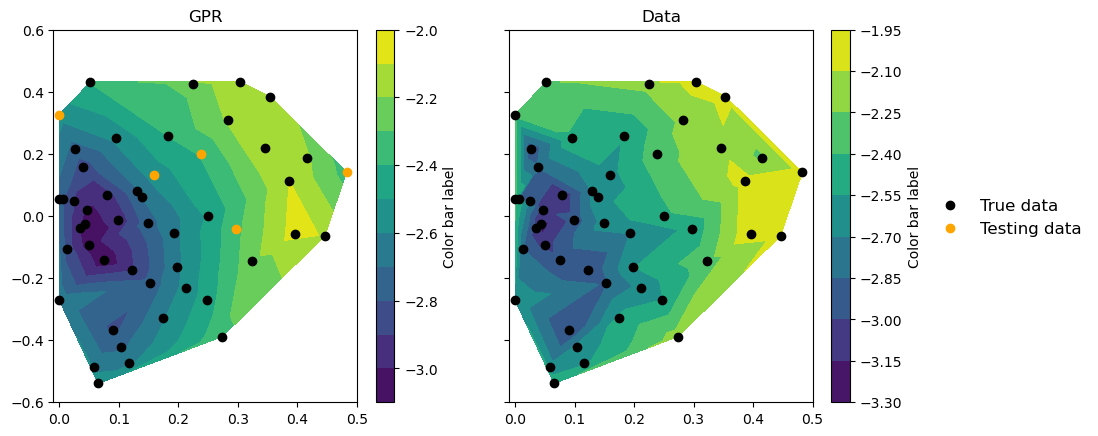

In [74]:
fig, ax = plt.subplots(1,2,sharex = True,sharey = True, figsize = (10,5))
ax[0].set_xlim((-0.01,0.5))
ax[0].set_ylim((-0.6,.6))
ax[0].set_title('GPR')
ax[0].plot(*X_train.T,'ko',label = 'True data')  # Training samples
ax[0].plot(*X_test.T, marker='o', color='orange', linestyle='none', label='Testing data')
contour = ax[0].tricontourf(x, y,zfit,levels = 10, cmap="viridis")  # mean
cbar = plt.colorbar(contour, ax=ax[0], extend='both')  # Extend adds color to extreme values
cbar.set_label("Color bar label")  # Label for color bar
ax[1].set_xlim((-0.01,0.5))
ax[1].set_ylim((-0.6,.6))
ax[1].set_title('Data')
ax[1].plot(x, y, 'ko')  
contour1 = ax[1].tricontourf(x, y, z, levels=10, cmap="viridis")  
cbar = plt.colorbar(contour1, ax=ax[1], extend='both')  # Extend adds color to extreme values
cbar.set_label("Color bar label")  # Label for color bar
plt.tight_layout(pad=3)
fig.legend(loc='center left', bbox_to_anchor=(.95, 0.5), frameon=False,fontsize=12 )

## Cross-Cut on my GPR Process

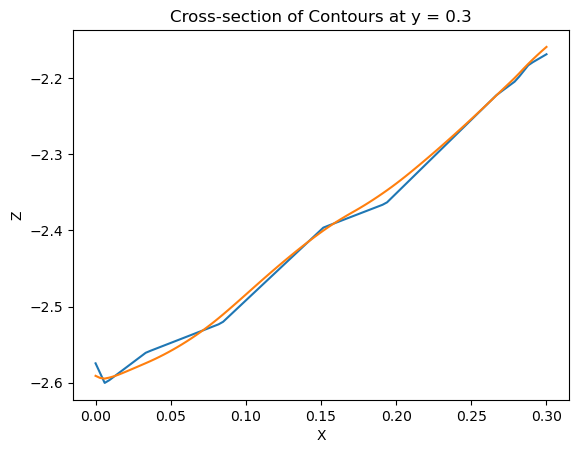

In [76]:
## Trying to cut section using 2d interpolation
## ISSUE WITH Xpoints since how do I know when to stop then . AS in in what regions do we know x
xpoints = np.linspace(0,0.3,100)
ypoint = 0.3

zgridlinear = interpolate.griddata((x,y),zfit,(xpoints,ypoint),method = "linear")
zgridcubic = interpolate.griddata((x,y),zfit,(xpoints,ypoint),method = "cubic")
plt.figure()
plt.plot(xpoints,zgridlinear)
plt.plot(xpoints,zgridcubic)
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'Cross-section of Contours at y = {ypoint}')
plt.show()

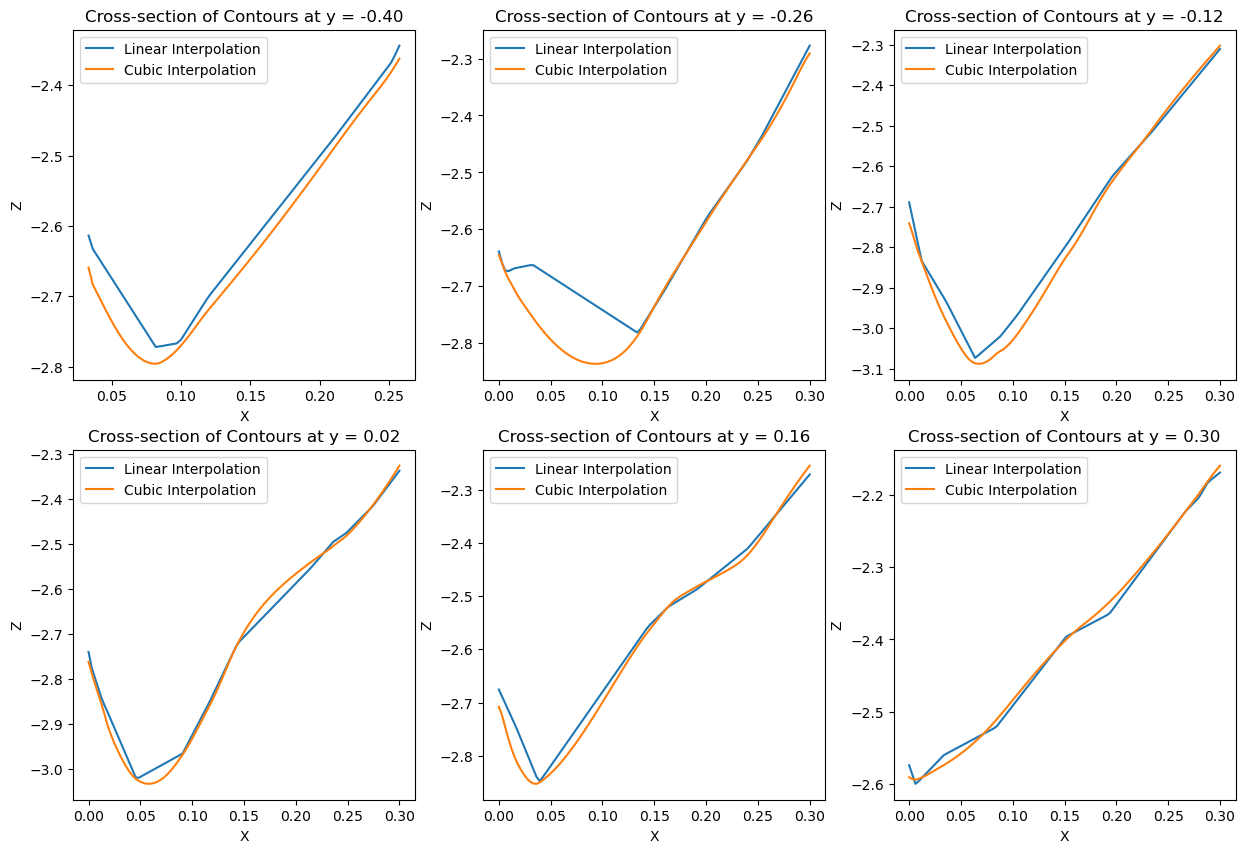

In [77]:
ypoints = np.linspace(-0.4, 0.3, 6)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loop through each ypoint to plot the cross-sections
for i, ypoint in enumerate(ypoints):
    ax = axes[i // 3, i % 3]
    zgridlinear = interpolate.griddata((x,y), zfit , (xpoints, ypoint), method="linear")
    zgridcubic = interpolate.griddata((x,y), zfit , (xpoints, ypoint), method="cubic")
    ax.plot(xpoints, zgridlinear, label="Linear Interpolation")
    ax.plot(xpoints, zgridcubic, label="Cubic Interpolation")
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_title(f'Cross-section of Contours at y = {ypoint:.2f}')
    ax.legend()

## Running through mp GPR 5 times to find which test points give the best L2 norm and can be removed for testing

In [81]:
#X = np.column_stack((x.reshape(-1), y.reshape(-1)))
#Z = (z).reshape(-1,1)
guess_l = (1., 1.)  
bounds_l = ((1e-20,1.),) * 2  
guess_n = 1.  
bounds_n = (1e-20, 1.) 
kernel = (RBF(length_scale=guess_l, length_scale_bounds=bounds_l)+ WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n))

In [84]:
step = 5
n = len(x)
## int 1 0,5,10,15,20,25,30,35,40,45,50
## int 2 1,6,11,16,21,26,31,36,41,46,51
## int 3 2,7,12,17,22,27,32,37,42,47,52
## int 4 3,8,13,18,23,28,33,38,43,48,53
## int 5 4,9,14,19,24,29,34,39,44,49,54

testnum = (n // step) + (1 if n % step != 0 else 0)

xindices = np.arange(n)
for start in range(step):
    i=0
    index = []
    while (start + i * step) < n and len(index) < testnum:
        index.append(start+i*step)
        i+= 1
    while len(index) < testnum:
        index.append(n - 1)
    train_indices = np.delete(xindices,index)
    test_indices = np.array(index)
    X_train = X[train_indices]
    X_test = X[test_indices]
    Z_train = Z[train_indices]
    Z_test = Z[test_indices]
    gpr = GaussianProcessRegressor(kernel,normalize_y=True ,n_restarts_optimizer=10)
    gpr.fit(X_train, Z_train)
    print(gpr.kernel_)
    Zfit, Zstd = gpr.predict(X, return_std=True)
    #zstd = Zstd.reshape(x.shape)
    zfit = Zfit.reshape(x.shape)
    ### FIXME
    l2_norm = (1/testnum)*np.linalg.norm(zfit - z)
    print(l2_norm)

RBF(length_scale=[0.203, 0.4]) + WhiteKernel(noise_level=0.246)
0.10495056332090534
RBF(length_scale=[0.0915, 0.299]) + WhiteKernel(noise_level=0.0754)
0.08744047011657334
RBF(length_scale=[0.198, 0.43]) + WhiteKernel(noise_level=0.253)
0.11464816347325052
RBF(length_scale=[0.0689, 0.321]) + WhiteKernel(noise_level=0.149)
0.08553852102182417
RBF(length_scale=[0.164, 0.403]) + WhiteKernel(noise_level=0.234)
0.10255853283171812
